In [35]:
# Import libraries
import warnings                       
import numpy as np                    
import pandas as pd                   
import matplotlib.pyplot as plt      
import xgboost as xgb
import seaborn as sns
import os
import torch
import torchvision
import cv2
import imutils
import hashlib
import torchvision.models as models

# Import functions 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score, f1_score, make_scorer, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, OneHotEncoder, PowerTransformer, SplineTransformer, KBinsDiscretizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline 
from scipy.stats import poisson, uniform
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import make_circles, make_friedman1
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.impute import KNNImputer
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import random
import matplotlib.image as mpimg
from skimage import io
from torch.nn import functional 
from torchvision import transforms
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torchvision.models import MobileNet_V2_Weights

# Suppress common warnings 
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.filterwarnings("ignore")

The data is available on Kaggle at: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download

### 1) Preprocess the MRI scans

#### 1.1) Crop the scans to the same size

In [2]:
# Code provided by Kaggle at: https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

### Define a function that finds the extreme points on the image and crops the rectangular out of them 
# This can be used to isolate the main object (brain) from MRI scans
def crop_img(img):
    
	# Convert the image from RGB/BGR to grayscale 
    # MRI images do not use color information, so grayscale simplifies processing
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

	# Apply a Gaussian blur to smooth noise and small variations
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# Convert grayscale to a binary image where: pixel > 45 => white (255), pixel ≤ 45 => black (0)
	# This isolates the bright brain region from dark background.
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

	# Erode to remove small white noise blobs
	thresh = cv2.erode(thresh, None, iterations = 2)

	# Dilate to restore the main white region (the brain) after erosion
	thresh = cv2.dilate(thresh, None, iterations = 2)

	# Find contours in the thresholded mask (RETR_EXTERNAL retrieves only the largest external contour)
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

	# imutils.grab_contours ensures compatibility across OpenCV versions
	cnts = imutils.grab_contours(cnts)

	# Select the largest contour by area (MRI brain region is the biggest object)
	c = max(cnts, key = cv2.contourArea)

    # Find the extreme points of the largest contour
	# Leftmost x-coordinate
	extLeft = tuple(c[c[:, :, 0].argmin()][0])

	# Rightmost x-coordinate
	extRight = tuple(c[c[:, :, 0].argmax()][0])

	# Topmost y-coordinate
	extTop = tuple(c[c[:, :, 1].argmin()][0])

	# Bottommost y-coordinate
	extBot = tuple(c[c[:, :, 1].argmax()][0])

	# Extra padding around the crop
	ADD_PIXELS = 0

	# Crop the original image using the extreme coordinates to isolate the brain region tightly
	new_img = img[
		extTop[1] - ADD_PIXELS : extBot[1] + ADD_PIXELS,
		extLeft[0] - ADD_PIXELS : extRight[0] + ADD_PIXELS
	].copy()
	
	return new_img


### Apply brain cropping to all scans in both training and testing folders
if __name__ == "__main__":

	# Input directories where original MRI scans are stored
	training = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/Training/"
	testing = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/Testing/"

	# List class folders / patient folders
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)

	# Final image size for normalization 
	IMG_SIZE = 256

	### Process training set
	for dir in training_dir:

		# Output path for cleaned (cropped/resized) scans
		save_path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTraining/" + dir

		# Path to original training scans folder
		path = os.path.join(training, dir)

		# Avoid .DS_Store
		if not os.path.isdir(path):
			continue

		# List images inside this folder
		image_dir = os.listdir(path)

		for img in image_dir:

			# Read raw MRI scan
			image = cv2.imread(os.path.join(path, img))

			# Crop brain region using the function 
			new_img = crop_img(image)

			# Resize to 256×256 so the model receives consistent inputs
			new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

			# Create output folder if it does not exist already
			if not os.path.exists(save_path):
				os.makedirs(save_path)

			# Save cleaned scan
			cv2.imwrite(save_path + '/' + img, new_img)

	### Process testing set
	for dir in testing_dir:

		# Output path for cleaned test images
		save_path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTesting/" + dir

		# Path to original testing scans folder
		path = os.path.join(testing, dir)

		# Avoid .DS_Store
		if not os.path.isdir(path):
			continue

		# List images inside this folder
		image_dir = os.listdir(path)

		for img in image_dir:

            # Read raw MRI scan
			image = cv2.imread(os.path.join(path,img))

            # Crop brain region using the function 
			new_img = crop_img(image)

            # Resize to 256×256 so the model receives consistent inputs
			new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            # Create output folder if it does not exist already
			if not os.path.exists(save_path):
				os.makedirs(save_path)

            # Save cleaned scan
			cv2.imwrite(save_path + '/' + img, new_img)

#### 1.2) Import processed training scans

In [3]:
### "Notumor" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTraining/notumor/"

# Get a list all filenames in the folder
img_train_notumor = os.listdir(path)

# Count the number of scans in this folder
len_train_notumor = len(img_train_notumor)

# Create an empty Numpy array to store notumor scans
# Format: (Number of images, Height, Width, Color Channels)
images_train_notumor = np.empty(shape = (len_train_notumor, 256, 256, 3))

# Label 0 for notumor
labels_train_notumor = [0] * len_train_notumor

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_train_notumor):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_train_notumor[idx] = image

In [4]:
### "Glioma" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTraining/glioma/"

# Get a list all filenames in the folder
img_train_glioma = os.listdir(path)

# Count the number of scans in this folder
len_train_glioma = len(img_train_glioma)

# Create an empty Numpy array to store glioma scans
# Format: (Number of images, Height, Width, Color Channels)
images_train_glioma = np.empty(shape = (len_train_glioma, 256, 256, 3))

# Label 1 for glioma
labels_train_glioma = [1] * len_train_glioma

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_train_glioma):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_train_glioma[idx] = image

In [5]:
### "Meningioma" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTraining/meningioma/"

# Get a list all filenames in the folder
img_train_meningioma = os.listdir(path)

# Count the number of scans in this folder
len_train_meningioma = len(img_train_meningioma)

# Create an empty Numpy array to store meningioma scans
# Format: (Number of images, Height, Width, Color Channels)
images_train_meningioma = np.empty(shape = (len_train_meningioma, 256, 256, 3))

# Label 2 for meningioma
labels_train_meningioma = [2] * len_train_meningioma

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_train_meningioma):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_train_meningioma[idx] = image

In [6]:
### "Pituitary" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTraining/pituitary/"

# Get a list all filenames in the folder
img_train_pituitary = os.listdir(path)

# Count the number of scans in this folder
len_train_pituitary = len(img_train_pituitary)

# Create an empty Numpy array to store pituitary scans
# Format: (Number of images, Height, Width, Color Channels)
images_train_pituitary = np.empty(shape = (len_train_pituitary, 256, 256, 3))

# Label 3 for pituitary
labels_train_pituitary = [3] * len_train_pituitary

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_train_pituitary):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_train_pituitary[idx] = image

#### 1.3) Import processed testing scans 

In [7]:
### "Notumor" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTesting/notumor/"

# Get a list all filenames in the folder
img_test_notumor = os.listdir(path)

# Count the number of scans in this folder
len_test_notumor = len(img_test_notumor)

# Create an empty Numpy array to store notumor scans
# Format: (Number of images, Height, Width, Color Channels)
images_test_notumor = np.empty(shape = (len_test_notumor, 256, 256, 3))

# Label 0 for notumor
labels_test_notumor = [0] * len_test_notumor

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_test_notumor):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_test_notumor[idx] = image

In [8]:
### "Glioma" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTesting/glioma/"

# Get a list all filenames in the folder
img_test_glioma = os.listdir(path)

# Count the number of scans in this folder
len_test_glioma = len(img_test_glioma)

# Create an empty Numpy array to store glioma scans
# Format: (Number of images, Height, Width, Color Channels)
images_test_glioma = np.empty(shape = (len_test_glioma, 256, 256, 3))

# Label 1 for glioma
labels_test_glioma = [1] * len_test_glioma

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_test_glioma):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_test_glioma[idx] = image

In [9]:
### "Meningioma" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTesting/meningioma/"

# Get a list all filenames in the folder
img_test_meningioma = os.listdir(path)

# Count the number of scans in this folder
len_test_meningioma = len(img_test_meningioma)

# Create an empty Numpy array to store meningioma scans
# Format: (Number of images, Height, Width, Color Channels)
images_test_meningioma = np.empty(shape = (len_test_meningioma, 256, 256, 3))

# Label 2 for meningioma
labels_test_meningioma = [2] * len_test_meningioma

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_test_meningioma):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_test_meningioma[idx] = image

In [10]:
### "Pituitary" Class

# Define the directory path containing processed scans  
path = "/Users/manhduynguyen/Desktop/Grinnell/Fall 2025/STA-395-01/Project/cleanTesting/pituitary/"

# Get a list all filenames in the folder
img_test_pituitary = os.listdir(path)

# Count the number of scans in this folder
len_test_pituitary = len(img_test_pituitary)

# Create an empty Numpy array to store pituitary scans
# Format: (Number of images, Height, Width, Color Channels)
images_test_pituitary = np.empty(shape = (len_test_pituitary, 256, 256, 3))

# Label 3 for pituitary
labels_test_pituitary = [3] * len_test_pituitary

# Loop through each scan and import them into the empty array
for idx, name in enumerate(img_test_pituitary):

    # Define full file path for the current scan
    img_name = path + name

    # Read the scan
    image = plt.imread(img_name)

    # Store the scan in the array
    images_test_pituitary[idx] = image

#### 1.4) Combine the scans for training and testing set

In [11]:
### Training set

# Combine the scans 
train_images = np.concatenate([images_train_notumor,
                               images_train_glioma,
                               images_train_meningioma,
                               images_train_pituitary], axis = 0)

# Combine the labels 
train_labels = np.concatenate([labels_train_notumor, 
                               labels_train_glioma, 
                               labels_train_meningioma, 
                               labels_train_pituitary], axis = 0)

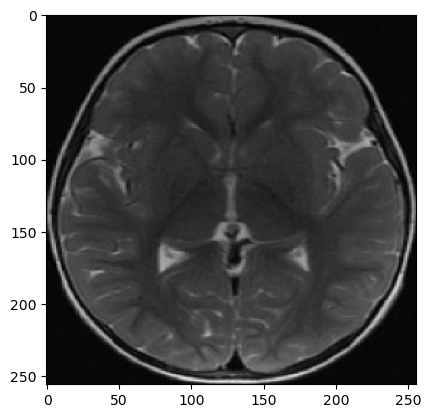

In [12]:
# Check the scans 
plt.imshow(train_images[86].astype("uint8"))

In [13]:
# Check the labels
print(train_labels[1])

0


In [14]:
### Testing set

# Combine the scans 
test_images = np.concatenate([images_test_notumor,
                              images_test_glioma,
                              images_test_meningioma,
                              images_test_pituitary], axis = 0)

# Combine the labels 
test_labels = np.concatenate([labels_test_notumor, 
                              labels_test_glioma, 
                              labels_test_meningioma, 
                              labels_test_pituitary], axis = 0)

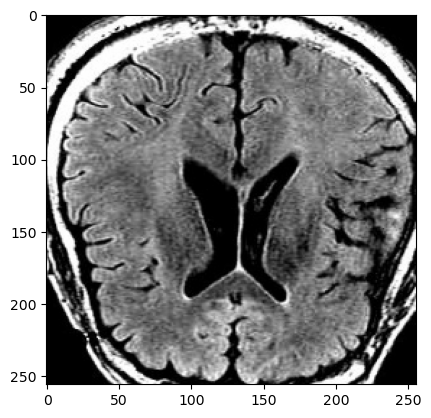

In [15]:
# Check the scans 
plt.imshow(test_images[20].astype("uint8"))

In [16]:
# Check the labels
print(test_labels[20])

0


#### 1.5) Check for duplicate scans in each set

In [17]:
# Define the function to compute unique hash for a scan using MD5

# get_image_hash(img) creates a unique fingerprint for an image by converting the entire NumPy array of 
# pixel values into a raw byte stream (img.tobytes()) and then computing its MD5 hash. Because MD5 produces 
# a deterministic 32-character hexadecimal string, two images that are pixel-identical will always yield 
# the same hash. 

# Details on the hashlib library: https://docs.python.org/3/library/hashlib.html

def get_image_hash(img):
    return hashlib.md5(img.tobytes()).hexdigest()

### Check duplicates within training set

# Initiate a dictionary to store unique image hashes 
train_hashes = {}

# Initiate the number of duplicates
train_duplicates = 0

# Loop through all scans in the training set 
for i, img in enumerate(train_images):

    # Generate hash for the current scan
    h = get_image_hash(img)

    # Increment the duplicate number if hash has been seen
    train_duplicates += h in train_hashes
    
    # Store hash with its index
    train_hashes[h] = i

# Calculate the summary statistics
train_unique = len(train_hashes)
train_total = len(train_images)
train_rate = train_duplicates / train_total * 100

print(f"Training Set Summary")
print("="*20)
print(f"Total scans: {train_total}")
print(f"Unique scans: {train_unique}")
print(f"Duplicates: {train_duplicates} ({train_rate:.1f}%)")

### Check duplicates within training set

# Initiate a dictionary to store unique image hashes 
test_hashes = {}

# Initiate the number of duplicates
test_duplicates = 0

# Loop through all scans in the testing set 
for i, img in enumerate(test_images):

    # Calculate hash for the current scan
    h = get_image_hash(img)

    # Increment the duplicate number if hash has been seen
    test_duplicates += h in test_hashes

    # Store hash with its index
    test_hashes[h] = i

# Calculate the summary statistics
test_unique = len(test_hashes)
test_total = len(test_images)
test_rate = test_duplicates / test_total * 100

print(f"\nTesting Set Summary")
print("="*20)
print(f"Total scans: {test_total}")
print(f"Unique scans: {test_unique}")
print(f"Duplicates: {test_duplicates} ({test_rate:.1f}%)")

Training Set Summary
Total scans: 5712
Unique scans: 5497
Duplicates: 215 (3.8%)

Testing Set Summary
Total scans: 1311
Unique scans: 1274
Duplicates: 37 (2.8%)


#### 1.6) Remove duplicate scans in each set

In [18]:
# Define the function to remove duplicate scans using hash
def remove_duplicates_using_hash(images, labels, set_name = "dataset"):

    # Initiate an empty set to store hashes of scans already seen
    # set() removes duplicates automatically 

    # Details on set(): https://www.geeksforgeeks.org/python/python-set-function/
    seen_hashes = set()
    
    # Initiate a list of indices of the scans that are unique
    keep_indices = []

    # Loop through all scans in the set
    for idx, img in enumerate(images):

        # Generate hash for the current scan 
        img_hash = get_image_hash(img)

        # If the current hash has not been seen, store it in seen_hashes and record the according index
        if img_hash not in seen_hashes:
            seen_hashes.add(img_hash)
            keep_indices.append(idx)
    
    # Create new arrays to store unique scans and their correponding labels 
    unique_images = images[keep_indices]
    unique_labels = labels[keep_indices]

    # Count the number of duplicates that has been removed
    removed_count = len(images) - len(unique_images)
    
    # Print summary statistics 
    print(f"\nOriginal scans in {set_name}: {len(images)}")
    print(f"Unique scans in {set_name}: {len(unique_images)}")
    print(f"Removed scans in {set_name}: {removed_count}")

    # Return the unique scans and their corresponding labels
    return unique_images, unique_labels

# Remove duplicates from training set
train_images_clean, train_labels_clean = remove_duplicates_using_hash(train_images, 
                                                                      train_labels, 
                                                                      "Training set")

# Remove duplicates from testing set  
test_images_clean, test_labels_clean = remove_duplicates_using_hash(test_images, 
                                                                    test_labels, 
                                                                    "Testing set")


Original scans in Training set: 5712
Unique scans in Training set: 5497
Removed scans in Training set: 215

Original scans in Testing set: 1311
Unique scans in Testing set: 1274
Removed scans in Testing set: 37


#### 1.7) Check for duplicate scans across the training and testing set 

In [19]:
# Initiate an empty set to store hashes of scans in cleaned training set
train_clean_hashes = set()

# Loop through all scans in the cleaned training set
for img in train_images_clean:
    
    # Generate hash for the current scan and add it to the set
    train_clean_hashes.add(get_image_hash(img))

# Initiate the number of duplicates
cross_duplicates = 0

# Loop through all scans in the cleaned testing set
for img in test_images_clean:

    # If the has of the current test scan has been seen in the training set 
    if get_image_hash(img) in train_clean_hashes:
        
        # Increment the duplicate number
        cross_duplicates += 1

# Calculate the summary statistics
cross_rate = cross_duplicates / len(test_images_clean) * 100

print(f"\nCross-set duplicates: {cross_duplicates}")
print(f"Data leakage rate: {cross_rate:.1f}% of the cleaned testing set")


Cross-set duplicates: 182
Data leakage rate: 14.3% of the cleaned testing set


#### 1.8) Remove cross-set duplicate scans in the testing set

In [20]:
# Initiate the empty dictionary to store both hash and index
train_hashes = {}

# Loop through all scans in the cleaned training set
for idx, img in enumerate(train_images_clean):
    
    # Generate hash for the current scan
    h = get_image_hash(img)

    # Store the current hash with its corresponding index
    train_hashes[h] = idx  

# Initiate a list to store index of unique scans in testing set
test_keep_indices = []

# Initiate the number of scans removed
test_removed_count = 0

# Loop through all scans in the cleaned testing set 
for idx, img in enumerate(test_images_clean):
    
    # Generate hash for the current scan
    h = get_image_hash(img)

    # If the current hash not been seen in the cleaned training set
    if h not in train_hashes:
        
        # Record the index 
        test_keep_indices.append(idx)
    
    # If the current hash has been seen in the cleaned training set
    else:
        # Increment the scan removed number
        test_removed_count += 1

# Create the new testing set
test_images_final = test_images_clean[test_keep_indices]
test_labels_final = test_labels_clean[test_keep_indices]

print(f"Cross-set duplicates removed: {test_removed_count}")

Cross-set duplicates removed: 182


#### 1.9) Check the tensor shape and the number of scans in each class

In [21]:
# Rename for uniformity
train_images_final = train_images_clean
train_labels_final = train_labels_clean

test_images_final = test_images_final
test_labels_final = test_labels_final


# Check the tensor input shape
print(f"train_images_final shape: {train_images_final.shape}")
print(f"test_images_final shape: {test_images_final.shape}")

train_images_final shape: (5497, 256, 256, 3)
test_images_final shape: (1092, 256, 256, 3)


In [22]:
# Check the final number of scans in each class  
print(f"Training: glioma, meningioma, notumor, pituitary")
print(f"Counts:   {np.bincount(train_labels_final.astype(int))}")
print(f"\nTesting:  glioma, meningioma, notumor, pituitary")
print(f"Counts:   {np.bincount(test_labels_final.astype(int))}")

Training: glioma, meningioma, notumor, pituitary
Counts:   [1399 1321 1332 1445]

Testing:  glioma, meningioma, notumor, pituitary
Counts:   [300 299 198 295]


#### 1.10) Combine both set and redivide into 75%-25% training-testing for more balanced sets

In [23]:
# Combine both original final training and testing sets 
all_images_final = np.concatenate([train_images_final, test_images_final], axis = 0)
all_labels_final = np.concatenate([train_labels_final, test_labels_final], axis = 0)

# Stratify into new training and testing sets (75%-25%)
train_images_new , test_images_new, train_labels_new, test_labels_new = train_test_split(all_images_final, 
                                                                                         all_labels_final,
                                                                                         test_size = 0.25,
                                                                                         stratify = all_labels_final, 
                                                                                         random_state = 1)

# Check the new number of scans in each class  
print(f"Training: glioma, meningioma, notumor, pituitary")
print(f"Counts:   {np.bincount(train_labels_new.astype(int))}")
print(f"\nTesting:  glioma, meningioma, notumor, pituitary")
print(f"Counts:   {np.bincount(test_labels_new.astype(int))}")

Training: glioma, meningioma, notumor, pituitary
Counts:   [1274 1215 1147 1305]

Testing:  glioma, meningioma, notumor, pituitary
Counts:   [425 405 383 435]


### 2) Construct the CNN

#### 2.1) Augment the scans

In [24]:
data_transforms = transforms.Compose([
    # Gaussian blur with kernel size 3 and sigma to randomly pick blur intensity between 0.1 and 2.0
    transforms.GaussianBlur(kernel_size = 3, sigma = (0.1, 2.0)),
    
    # Random horizontal flip with 50% probability
    transforms.RandomHorizontalFlip(p = 0.5),
    
    # Random rotation by 30 degrees
    transforms.RandomRotation(30),

    # Random affine transformation with shear
    transforms.RandomAffine(degrees = 0, shear = 10),

    # Random crop 90%-100% of the original area and resize back to 256x256 pixels
    transforms.RandomResizedCrop(256, scale = (0.9, 1.0))
])

#### 2.2) Define the custom network architecture

In [25]:
# The architecture is inspired by Hashemzehi et al. (2020): https://doi.org/10.1016/j.bbe.2020.06.001

# Define the CNN architecture
class GBMnet(nn.Module):
    
    def __init__(self):
        super(GBMnet, self).__init__()

        self.conv_stack = nn.Sequential(
            ### Layer 1  
            
            # Convolutional layer of 3x3 kernels with stride 1, padding 1, and 8 output channels
            # Input size = 3x256x256 | Output size = 8x256x256 
            nn.Conv2d(3, 8, kernel_size = 3, stride = 1, padding = 1),
            
            # Batch normalization
            # Input size = 8x256x256 | Output size = 8x256x256 
            nn.BatchNorm2d(8),

            # ReLU activation
            # Input size = 8x256x256 | Output size = 8x256x256
            nn.ReLU(),

            # Max pooling with 2x2 kernels
            # Input size = 8x256x256 | Output size = 8x128x128
            nn.MaxPool2d(2, 2),  

            ### Layer 2
            # Convolutional layer of 3x3 kernels with stride 1, padding 1, and 16 output channels
            # Input size = 8x128x128 | Output size = 16x128x128
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1),  

            # Batch normalization
            # Input size = 16x128x128 | Output size = 16x128x128
            nn.BatchNorm2d(16),
            
            # ReLU activation
            # Input size = 16x128x128 | Output size = 16x128x128
            nn.ReLU(),

            # Max pooling with 2x2 kernels
            # Input size = 16x128x128 | Output size = 16x64x64
            nn.MaxPool2d(2, 2),  

            ### Layer 3
            # Convolutional layer of 3x3 kernels with stride 1, padding 1, and 32 output channels
            # Input size = 16x64x64 | Output size = 32x64x64
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),  

            # Batch normalization
            # Input size = 32x64x64 | Output size = 32x64x64
            nn.BatchNorm2d(32),

            # ReLU activation
            # Input size = 32x64x64 | Output size = 32x64x64
            nn.ReLU(),

            # Max pooling with 2x2 kernels
            # Input size = 32x64x64 | Output size = 32x32x32
            nn.MaxPool2d(2, 2), 

            ### Layer 4
            # Convolutional layer of 3x3 kernels with stride 1, padding 1, and 64 output channels
            # Input size = 32x32x32 | Output size = 64x32x32
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),  
            
            # Batch normalization
            # Input size = 64x32x32 | Output size = 64x32x32
            nn.BatchNorm2d(64),
            
            # ReLU activation
            # Input size = 64x32x32 | Output size = 64x32x32
            nn.ReLU(),
            
            # Max pooling with 2x2 kernels
            # Input size = 64x32x32 | Output size = 64x16x16
            nn.MaxPool2d(2, 2),  

            # Flatten 
            nn.Flatten(),
            # Fully connected 64*14*14 features to 512 neurons 
            nn.Linear(64 * 16 * 16, 512),  
            # ReLU activation
            nn.ReLU(),
            # Add dropout rate for regularization
            nn.Dropout(0.3),
            # Output the 512 neurons to 4 classes
            nn.Linear(512, 4)
        )
    
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

#### 2.3) Define the transfer learning network from MobileNetV2

In [26]:
# Load the MobileNetv2 weights
MobileNetV2_weights = torchvision.models.MobileNet_V2_Weights.DEFAULT

# Set up the model with weights
MobileNetV2_model = torchvision.models.mobilenet_v2(weights = MobileNetV2_weights)

# Check the architecture and preprocessing transform
print(f"Architecture of MobileNetV2:")
print(MobileNetV2_model)

print(f"\nPreprocessing transforms of MobileNetV2:")
print(MobileNetV2_weights.transforms()) 

Architecture of MobileNetV2:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [31]:
# Application of MobileNetV2 in GBM MRI classification from Khan et al. (2025): https://doi.org/10.1007/s12672-025-02671-4

class GBM_MobileNetV2net(nn.Module):
    def __init__(self):
        super(GBM_MobileNetV2net, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights = MobileNet_V2_Weights.DEFAULT)
        
        # Freeze all convolutional feature extractor layers and unfreeze the last classifier layer 
        for param in self.base_model.features.parameters():
            param.requires_grad = False
        
        # Extract the final feature dimension before classifier layer 
        in_features = self.base_model.classifier[1].in_features

        # Replace the default classifier with the new one for the 4 classes of GBM
        self.base_model.classifier = nn.Sequential(
            # Fully connected layer to 64 neurons 
            nn.Linear(in_features, 64),
            # ReLU activation
            nn.ReLU(),
            # Add dropout rate for regularization to prevent overfitting
            nn.Dropout(0.5),
            # Output the 64 neurons to 4 classes
            nn.Linear(64, 4)
        )
    
    def forward(self, x):
        x = nn.functional.interpolate(x, size = (224, 224), mode = "bilinear")
        scores = self.base_model(x)  
        return scores

### 3) Train the CNN

#### 3.1) Create the train loader

In [45]:
# Set seed
torch.manual_seed(1)

# Convert training labels to a PyTorch tensor  
train_y_tensor = torch.Tensor(train_labels_new)

# Converting the array to a tensor and then switching the dimensions
# Since permute() creates a non-contiguous memory view that can cause errors in convolution, contiguous() ensures the tensor is stored sequentially in memory
# float() converts the tensore into float32 for gradient calculations as image data often come in the form of uint8 integers (pixels)

# Details on contiguous(): https://docs.pytorch.org/docs/stable/generated/torch.Tensor.contiguous.html

train_tensor = torch.from_numpy(train_images_new).permute(0, 3, 1, 2).contiguous().float()

# Check the shape of the training tensor
print(train_tensor.shape)

# Create DataLoader for training set with batch size 32
train_loader = DataLoader(
    TensorDataset(train_tensor.type(torch.FloatTensor), train_y_tensor.type(torch.LongTensor)), 
    batch_size = 32)

torch.Size([4941, 3, 256, 256])


#### 3.2) Create the test loader

In [46]:
# Set seed
torch.manual_seed(1)

# Convert training labels to a PyTorch tensor  
test_y_tensor = torch.Tensor(test_labels_new)

# Converting the array to a tensor and then switching the dimensions
# Since permute() creates a non-contiguous memory view that can cause errors in convolution, contiguous() ensures the tensor is stored sequentially in memory
# float() converts the tensore into float32 for gradient calculations as image data often come in the form of uint8 integers (pixels)

# Details on contiguous(): https://docs.pytorch.org/docs/stable/generated/torch.Tensor.contiguous.html

test_tensor = torch.from_numpy(test_images_new).permute(0, 3, 1, 2).contiguous().float()

# Check the shape of the testing tensor
print(test_tensor.shape)

# Create DataLoader for training set with batch size 32
test_loader = DataLoader(
    TensorDataset(test_tensor.type(torch.FloatTensor), test_y_tensor.type(torch.LongTensor)), 
    batch_size = 32)

torch.Size([1648, 3, 256, 256])


#### 3.2) Train the custom CNN

Using device: mps
Epoch 20/200, Cost: 0.92, Train Accuracy: 83.42%
Epoch 40/200, Cost: 0.87, Train Accuracy: 87.86%
Epoch 60/200, Cost: 0.86, Train Accuracy: 89.17%
Epoch 80/200, Cost: 0.84, Train Accuracy: 90.89%
Epoch 100/200, Cost: 0.83, Train Accuracy: 91.82%
Epoch 120/200, Cost: 0.82, Train Accuracy: 92.73%
Epoch 140/200, Cost: 0.81, Train Accuracy: 93.62%
Epoch 160/200, Cost: 0.81, Train Accuracy: 94.45%
Epoch 180/200, Cost: 0.80, Train Accuracy: 94.80%
Epoch 200/200, Cost: 0.79, Train Accuracy: 95.55%

Final Results:
Training Accuracy: 95.55%


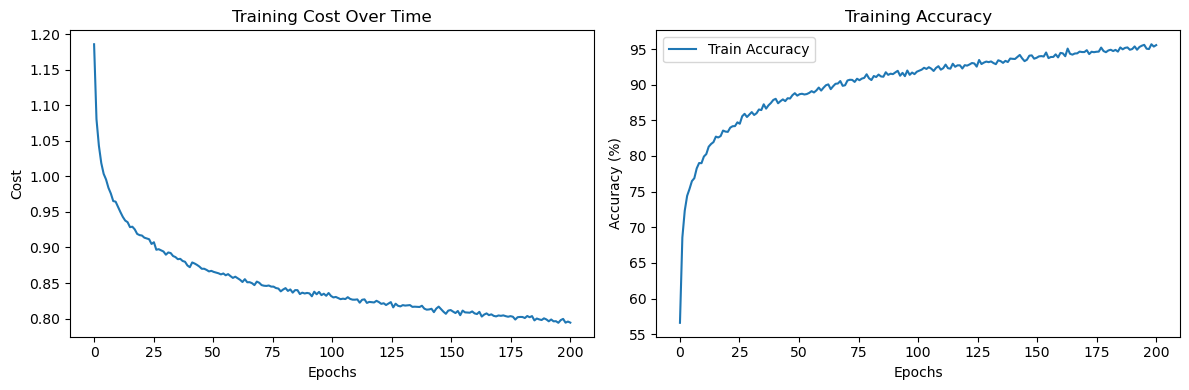

In [32]:
# Set seed
torch.manual_seed(1)

# Hyperparameters  
epochs = 200                         # Total number of training cycles through the dataset
lrate = 0.00001                      # Learning rate for the optimizer
bsize = 32                           # Batch size 

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define cost function (cross-entropy for classification)  
cost_fn = nn.CrossEntropyLoss()   # Loss function measuring prediction error for classification

# Initialize the neural network model  
GBMnet_model = GBMnet().to(device)                    

# Define optimizer 
optimizer = torch.optim.Adam(GBMnet_model.parameters(), lr = lrate)  

# Initialize arrays to track cost and accuracy over epochs  
track_cost = np.zeros(epochs)     # Array to store training cost per epoch
train_accuracy = np.zeros(epochs) # Array to store accuracy per epoch

# Store predictions for confusion matrix
all_train_preds_custom = []
all_train_labels_custom = []

for epoch in range(epochs):        # Loop through each training epoch
    cur_cost = 0.0                 # Running total of batch losses for this epoch
    correct_train = 0              # Counter for correct predictions
    total_train = 0                # Counter for total samples seen

    # Set model to training mode
    GBMnet_model.train()

    # Clear predictions for this epoch
    epoch_preds = []
    epoch_labels = []
    
    # Iterate over batches in the training DataLoader  
    for i, data in enumerate(train_loader, 0):   # Loop through each mini-batch
        inputs, labels = data                    # Extract images (inputs) and targets (labels)
        inputs, labels = inputs.to(device), labels.to(device)  # Transfer the data to device 
        inputs = data_transforms(inputs)                       # Transform the data 
        
        
        optimizer.zero_grad()                                 # Clear previous gradients
        outputs = GBMnet_model(inputs)                        # Forward pass through the network
        cost = cost_fn(nn.Softmax(dim = 1)(outputs), labels)  # Compute loss for this batch
        cost.backward()                                       # Compute gradients via backpropagation
        optimizer.step()                                      # Update model parameters
        cur_cost += cost.item()                               # Add batch loss to epoch total
        
        _, predicted = torch.max(outputs.data, 1)             # Get predicted class for each sample
        total_train += labels.size(0)                         # Count total samples
        correct_train += (predicted == labels).sum().item()   # Count correct predictions

        # Store predictions and labels for this batch
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

    # Store final epoch predictions 
    if epoch == epochs - 1:
        all_train_preds_custom = epoch_preds
        all_train_labels_custom = epoch_labels
    
    track_cost[epoch] = cur_cost / len(train_loader)          # Record average epoch loss
    train_accuracy[epoch] = 100 * correct_train / total_train # Compute epoch accuracy
    
    if (epoch + 1) % 20 == 0:                                 # Print progress every 20 epochs
        print(f"Epoch {epoch+1}/{epochs}, Cost: {track_cost[epoch]:.2f}, "
              f"Train Accuracy: {train_accuracy[epoch]:.2f}%")

# Final results
print(f"\nFinal Results:")                              # Header for final metrics
print(f"Training Accuracy: {train_accuracy[-1]:.2f}%")  # Print final accuracy

# Plot training cost and accuracy over epochs  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

ax1.plot(np.linspace(0, epochs, epochs), track_cost)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cost")
ax1.set_title("Training Cost Over Time")

ax2.plot(np.linspace(0, epochs, epochs), train_accuracy, label = "Train Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

#### 3.3) Validate the custom CNN


TRAINING SET EVALUATION

 Training Balanced Accuracy: 95.41% 


TRAINING SET CLASSIFICATION REPORT FOR CUSTOM CNN
              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98      1274
  meningioma       0.96      0.93      0.95      1215
     notumor       0.92      0.92      0.92      1147
   pituitary       0.96      0.98      0.97      1305

    accuracy                           0.96      4941
   macro avg       0.95      0.95      0.95      4941
weighted avg       0.96      0.96      0.96      4941



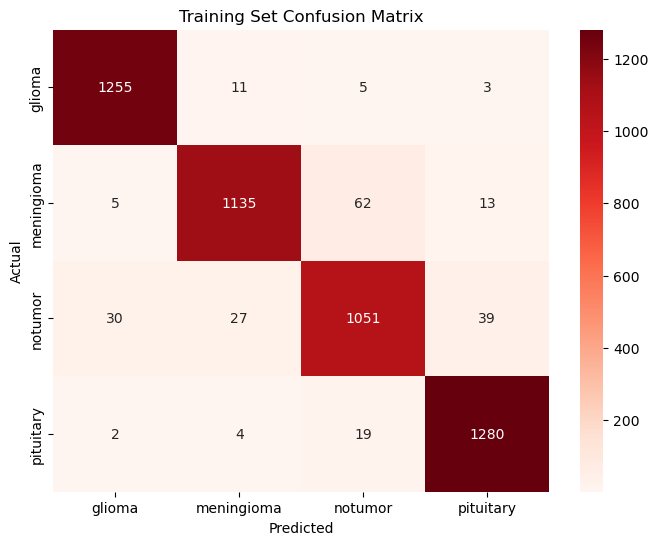


TESTING SET EVALUATION
Testing Accuracy: 90.66%
Testing Balanced Accuracy: 90.15%

TESTING SET CLASSIFICATION REPORT FOR CUSTOM CNN
              precision    recall  f1-score   support

      glioma       0.96      0.98      0.97       425
  meningioma       0.89      0.93      0.91       405
     notumor       0.92      0.71      0.80       383
   pituitary       0.87      0.98      0.92       435

    accuracy                           0.91      1648
   macro avg       0.91      0.90      0.90      1648
weighted avg       0.91      0.91      0.90      1648



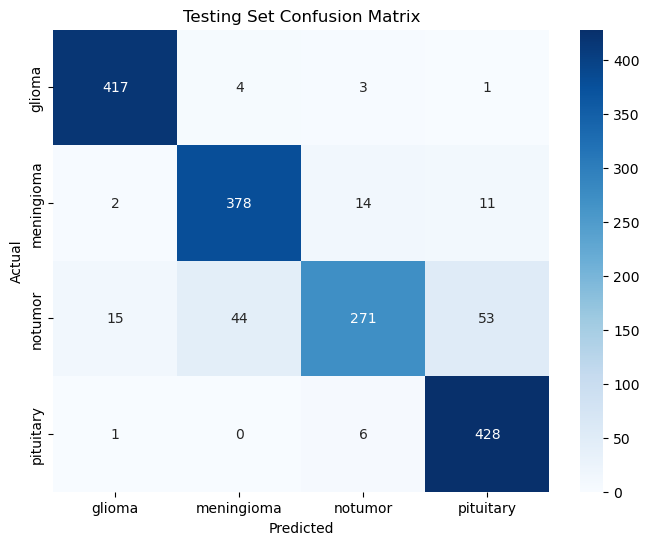

In [41]:
# Set seed
torch.manual_seed(1)

### Training Set
print("\n" + "=" * 20)
print("TRAINING SET EVALUATION")
print("=" * 20)

# Calculate balanced accuracy
train_bal_acc_custom = balanced_accuracy_score(all_train_labels_custom, all_train_preds_custom)
print(f"\n Training Balanced Accuracy: {train_bal_acc_custom * 100:.2f}% \n")

print("\n" + "=" * 20)
print("TRAINING SET CLASSIFICATION REPORT FOR CUSTOM CNN")
print("=" * 20)

# Define class labels
class_names_custom = ["glioma", "meningioma", "notumor", "pituitary"]

# Display precision, recall, F1, and support for each class 
print(classification_report(all_train_labels_custom, all_train_preds_custom, target_names = class_names_custom))

# Compute the confusion matrix comparing actual vs predicted training labels 
train_cm_custom = confusion_matrix(all_train_labels_custom, all_train_preds_custom)

# Plot the confusion matrix with heatmap labels
plt.figure(figsize = (8, 6))
sns.heatmap(train_cm_custom, annot = True, fmt = "d", cmap = "Reds",
            xticklabels = class_names_custom, yticklabels = class_names_custom)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Training Set Confusion Matrix")
plt.show()

### Testing Set
print("\n" + "=" * 20)
print("TESTING SET EVALUATION")
print("=" * 20)

# Initiate the counter for correctly classified test scans and total number of test scans 
test_correct = 0
test_total = 0

# Initiate the list to store all predicted labels and true labels from the testing set
test_all_preds_custom = []
test_all_labels_custom = []

# Set model to evaluation mode
GBMnet_model.eval()

# Disable gradient descent computation 
with torch.no_grad():
    # Loop over each batch of images and labels in the test loader
    for images, labels in test_loader:
        # Move data to device 
        images, labels = images.to(device), labels.to(device)  

        # Forward pass through the network
        outputs = GBMnet_model(images)

        # Select the class with the highest score for each scan
        _, predicted = torch.max(outputs.data, 1)

        # Update the total number of test scan
        test_total += labels.size(0)

        # Count correctly classified scans in the batch 
        test_correct += (predicted == labels).sum().item()

        # Store predicted and true labels (moved back to CPU)
        test_all_preds_custom.extend(predicted.cpu().numpy())
        test_all_labels_custom.extend(labels.cpu().numpy())

# Calculate the overall classification accuracy on the testing set 
test_accuracy = 100 * test_correct / test_total 
test_bal_acc_custom = balanced_accuracy_score(test_all_labels_custom, test_all_preds_custom)

print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"Testing Balanced Accuracy: {test_bal_acc_custom * 100:.2f}%")

print("\n" + "=" * 20)
print("TESTING SET CLASSIFICATION REPORT FOR CUSTOM CNN")
print("=" * 20)

# Display precision, recall, F1, and support for each class 
print(classification_report(test_all_labels_custom, test_all_preds_custom, target_names = class_names_custom))

# Compute the confusion matrix comparing actual vs predicted testing labels 
test_cm_custom = confusion_matrix(test_all_labels_custom, test_all_preds_custom)

# Plot the confusion matrix with heatmap labels
plt.figure(figsize = (8, 6))
sns.heatmap(test_cm_custom, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = class_names_custom, yticklabels = class_names_custom)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Testing Set Confusion Matrix")
plt.show()

#### 3.4) Train the transfer learning network from MobileNetV2

Using device: mps
Epoch 20/200, Cost: 1.13, Train Accuracy: 75.69%
Epoch 40/200, Cost: 1.03, Train Accuracy: 78.14%
Epoch 60/200, Cost: 0.99, Train Accuracy: 80.15%
Epoch 80/200, Cost: 0.97, Train Accuracy: 80.71%
Epoch 100/200, Cost: 0.95, Train Accuracy: 82.33%
Epoch 120/200, Cost: 0.94, Train Accuracy: 82.84%
Epoch 140/200, Cost: 0.93, Train Accuracy: 83.28%
Epoch 160/200, Cost: 0.92, Train Accuracy: 83.83%
Epoch 180/200, Cost: 0.92, Train Accuracy: 84.72%
Epoch 200/200, Cost: 0.92, Train Accuracy: 84.21%

Final Results:
Training Accuracy: 84.21%


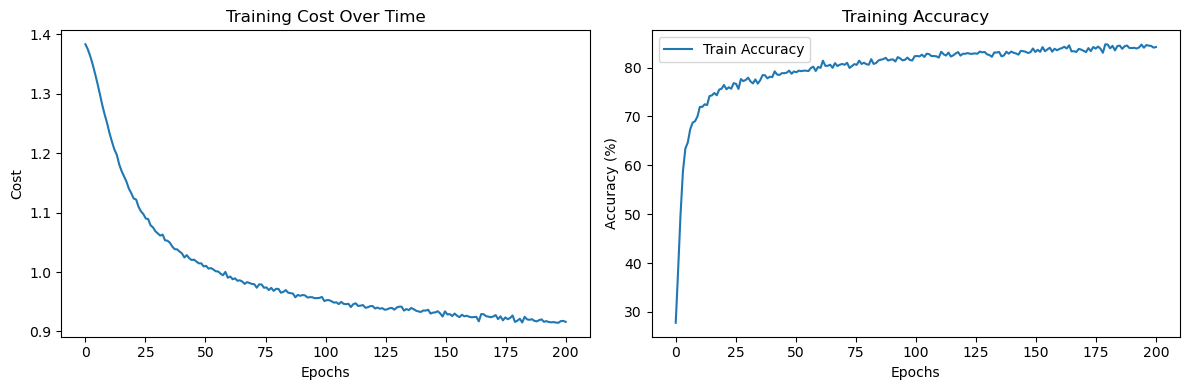

In [42]:
# Set seed
torch.manual_seed(1)

# Hyperparameters  
epochs = 200                          # Total number of training cycles through the dataset
lrate = 0.00001                       # Learning rate for the optimizer
bsize = 32                            # Batch size 

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define cost function (cross-entropy for classification)  
cost_fn = nn.CrossEntropyLoss()   # Loss function measuring prediction error for classification

# Initialize the neural network model  
GBM_MobileNetV2net_model = GBM_MobileNetV2net().to(device)                     

# Define optimizer 
optimizer = torch.optim.Adam(GBM_MobileNetV2net_model.parameters(), lr = lrate)  

# Initialize arrays to track cost and accuracy over epochs  
track_cost = np.zeros(epochs)     # Array to store training cost per epoch
train_accuracy = np.zeros(epochs) # Array to store accuracy per epoch

# Store predictions for confusion matrix
all_train_preds_tf = []
all_train_labels_tf = []

for epoch in range(epochs):        # Loop through each training epoch
    cur_cost = 0.0                 # Running total of batch losses for this epoch
    correct_train = 0              # Counter for correct predictions
    total_train = 0                # Counter for total samples seen

    # Set model to training mode
    GBM_MobileNetV2net_model.train()

    # Clear predictions for this epoch
    epoch_preds = []
    epoch_labels = []
    
    # Iterate over batches in the training DataLoader  
    for i, data in enumerate(train_loader, 0):   # Loop through each mini-batch
        inputs, labels = data                    # Extract images (inputs) and targets (labels)
        inputs, labels = inputs.to(device), labels.to(device)  # Transfer the data to device
        inputs = data_transforms(inputs)                       # Transform the data 
        
        optimizer.zero_grad()                                 # Clear previous gradients
        outputs = GBM_MobileNetV2net_model(inputs)            # Forward pass through the network
        cost = cost_fn(nn.Softmax(dim = 1)(outputs), labels)  # Compute loss for this batch
        cost.backward()                                       # Compute gradients via backpropagation
        optimizer.step()                                      # Update model parameters
        cur_cost += cost.item()                               # Add batch loss to epoch total
        
        _, predicted = torch.max(outputs.data, 1)             # Get predicted class for each sample
        total_train += labels.size(0)                         # Count total samples
        correct_train += (predicted == labels).sum().item()   # Count correct predictions

        # Store predictions and labels for this batch
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

    # Store final epoch predictions 
    if epoch == epochs - 1:
        all_train_preds_tf = epoch_preds
        all_train_labels_tf = epoch_labels
    
    track_cost[epoch] = cur_cost / len(train_loader)          # Record average epoch loss
    train_accuracy[epoch] = 100 * correct_train / total_train # Compute epoch accuracy
    
    if (epoch + 1) % 20 == 0:                                  # Print progress every 2 epochs
        print(f"Epoch {epoch+1}/{epochs}, Cost: {track_cost[epoch]:.2f}, "
              f"Train Accuracy: {train_accuracy[epoch]:.2f}%")

# Final results
print(f"\nFinal Results:")                              # Header for final metrics
print(f"Training Accuracy: {train_accuracy[-1]:.2f}%")  # Print final accuracy

# Plot training cost and accuracy over epochs  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

ax1.plot(np.linspace(0, epochs, epochs), track_cost)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cost")
ax1.set_title("Training Cost Over Time")

ax2.plot(np.linspace(0, epochs, epochs), train_accuracy, label = "Train Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

#### 3.5) Validate the transfer learning network from MobileNetV2


TRAINING SET EVALUATION

 Training Balanced Accuracy: 83.89% 


TRAINING SET CLASSIFICATION REPORT FOR TF CNN
              precision    recall  f1-score   support

      glioma       0.92      0.94      0.93      1274
  meningioma       0.87      0.78      0.82      1215
     notumor       0.73      0.75      0.74      1147
   pituitary       0.84      0.88      0.86      1305

    accuracy                           0.84      4941
   macro avg       0.84      0.84      0.84      4941
weighted avg       0.84      0.84      0.84      4941



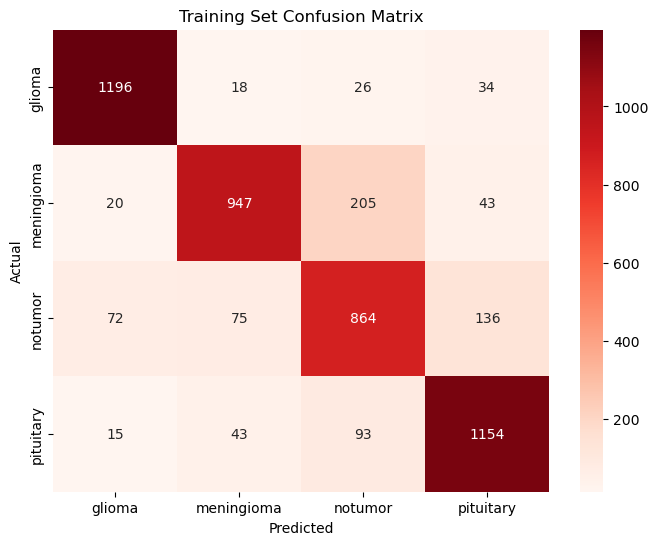


TESTING SET EVALUATION
Testing Accuracy: 77.31%
Testing Balanced Accuracy: 76.13%

TESTING SET CLASSIFICATION REPORT FOR TF CNN
              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       425
  meningioma       0.66      0.93      0.78       405
     notumor       0.87      0.26      0.40       383
   pituitary       0.74      0.93      0.82       435

    accuracy                           0.77      1648
   macro avg       0.80      0.76      0.73      1648
weighted avg       0.80      0.77      0.74      1648



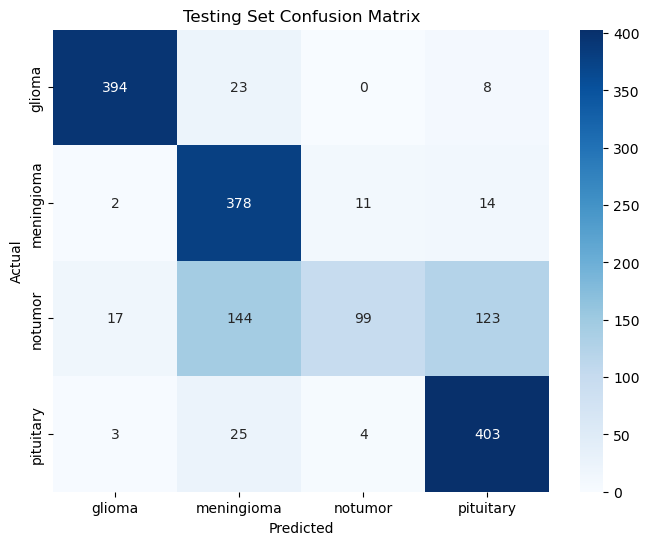

In [44]:
# Set seed
torch.manual_seed(1)

### Training Set
print("\n" + "=" * 20)
print("TRAINING SET EVALUATION")
print("=" * 20)

# Calculate balanced accuracy
train_bal_acc_tf = balanced_accuracy_score(all_train_labels_tf, all_train_preds_tf)
print(f"\n Training Balanced Accuracy: {train_bal_acc_tf * 100:.2f}% \n")

print("\n" + "=" * 20)
print("TRAINING SET CLASSIFICATION REPORT FOR TF CNN")
print("=" * 20)

# Define class labels
class_names_tf = ["glioma", "meningioma", "notumor", "pituitary"]

# Display precision, recall, F1, and support for each class 
print(classification_report(all_train_labels_tf, all_train_preds_tf, target_names = class_names_tf))

# Compute the confusion matrix comparing actual vs predicted training labels 
train_cm_tf = confusion_matrix(all_train_labels_tf, all_train_preds_tf)

# Plot the confusion matrix with heatmap labels
plt.figure(figsize = (8, 6))
sns.heatmap(train_cm_tf, annot = True, fmt = "d", cmap = "Reds",
            xticklabels = class_names_tf, yticklabels = class_names_tf)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Training Set Confusion Matrix")
plt.show()

### Testing Set
print("\n" + "=" * 20)
print("TESTING SET EVALUATION")
print("=" * 20)

# Initiate the counter for correctly classified test scans and total number of test scans 
test_correct = 0
test_total = 0

# Initiate the list to store all predicted labels and true labels from the testing set
test_all_preds_tf = []
test_all_labels_tf = []

# Set model to evaluation mode
GBM_MobileNetV2net_model.eval()

# Disable gradient descent computation 
with torch.no_grad():
    # Loop over each batch of images and labels in the test loader
    for images, labels in test_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device) 

        # Resize to 224x224 pixels for MobileNetV2 inputs
        images = nn.functional.interpolate(images, size = (224, 224), mode = "bilinear")

        # Forward pass through the network
        outputs = GBM_MobileNetV2net_model(images)
        
        # Select the class with the highest score for each scan
        _, predicted = torch.max(outputs.data, 1)

        # Update the total number of test scan
        test_total += labels.size(0)

        # Count correctly classified scans in the batch
        test_correct += (predicted == labels).sum().item()
        
        # Store predicted and true labels (moved back to CPU)
        test_all_preds_tf.extend(predicted.cpu().numpy())
        test_all_labels_tf.extend(labels.cpu().numpy())

# Calculate the overall classification accuracy on the testing set 
test_accuracy = 100 * test_correct / test_total
test_bal_acc_tf = balanced_accuracy_score(test_all_labels_tf, test_all_preds_tf)

print(f"Testing Accuracy: {test_accuracy:.2f}%")
print(f"Testing Balanced Accuracy: {test_bal_acc_tf * 100:.2f}%")

print("\n" + "=" * 20)
print("TESTING SET CLASSIFICATION REPORT FOR TF CNN")
print("=" * 20)

# Display precision, recall, F1, and support for each class 
print(classification_report(test_all_labels_tf, test_all_preds_tf, target_names = class_names_tf))

# Compute the confusion matrix comparing actual vs predicted testing labels 
test_cm_tf = confusion_matrix(test_all_labels_tf, test_all_preds_tf)

# Plot the confusion matrix with heatmap labels
plt.figure(figsize = (8, 6))
sns.heatmap(test_cm_tf, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = class_names_tf, yticklabels = class_names_tf)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Testing Set Confusion Matrix")
plt.show()